In [2]:
from lemaitre import bandpasses
filterlib=bandpasses.get_filterlib()

2025-01-29 14:42:04,968 INFO NumExpr defaulting to 12 threads.
2025-01-29 14:42:19,272 INFO loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.e6bf3ada09e4924f0f2b01c0619d97de11296ba5a7c236c66b125d5d3b11041b.pkl


In [3]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-01-29 14:42:33,230 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-01-29 14:42:33,233 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-01-29 14:42:37,245 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-01-29 14:42:37,371 INFO loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.e6bf3ada09e4924f0f2b01c0619d97de11296ba5a7c236c66b125d5d3b11041b.pkl
INFO:2025-01-29 14:42:42,582:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-29 14:42:42,582 INFO Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-29 14:42:42,644:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-01-29 14:42:42,644 INFO Unable to initialize backend 'tpu': INTERNA

In [4]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [5]:
%matplotlib inline

In [6]:
survey_colors=dict(ZTF="tab:blue",
                   SNLS="tab:orange",
                   HSC="tab:green")

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not anisotrope 

In [7]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM, z_at_value, Planck15
cosmo = FlatLambdaCDM(name="2m++",
                      H0=68.1,
                      Om0=0.306)

##### First loading

In [57]:
import h5py
with h5py.File("/cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/hbt_subhalos_0.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file['Subhalos']))
    cosmo_params={params:np.array(file['Cosmology'][params])[0] for params in list(file['Cosmology'])}
    positions = np.array(file['Subhalos']['ComovingAveragePosition'])
    positions_mostbound = np.array(file['Subhalos']['ComovingMostBoundPosition'])
    masses = np.array(file['Subhalos']['BoundM200Crit'])
    velocities = np.array(file['Subhalos']['PhysicalAverageVelocity'])
    ids = np.array(file['Subhalos']['HostHaloId'])
    rmax = np.array(file['Subhalos']['RmaxComoving'])    

Keys: <KeysViewHDF5 ['Cosmology', 'Subhalos']>
['BoundM200Crit', 'BoundR200CritComoving', 'ComovingAveragePosition', 'ComovingMostBoundPosition', 'HostHaloId', 'Nbound', 'PhysicalAverageVelocity', 'PhysicalMostBoundVelocity', 'RmaxComoving', 'TrackId', 'VmaxPhysical']


In [9]:
halos = pandas.DataFrame({"pos_x":positions.T[0]-500,
                  "pos_y":positions.T[1]-500,
                  "pos_z":positions.T[2]-500,
                  "vx":velocities.T[0],
                  "vy":velocities.T[1],
                  "vz":velocities.T[2],
                  "M200c":masses,
                  "halo_id":ids,
                  "Rmax":rmax})


halos["d_c"]=np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"]=(halos.pos_x*halos.vx + halos.pos_y*halos.vy + halos.pos_z*halos.vz)/halos.d_c


In [58]:
from astropy.cosmology import FlatLambdaCDM, z_at_value, Planck15
cosmo = FlatLambdaCDM(name="2m++",
                      H0=cosmo_params["HubbleParam"],
                      Om0=cosmo_params["OmegaM0"])

In [64]:
from scipy.interpolate import interp1d
dc_to_z = interp1d(cosmo.comoving_distance(np.linspace(1e-3, 0.5, 10000)),np.linspace(1e-3, 0.5, 10000))

In [48]:
halos['z_cosmo'] = dc_to_z(halos.d_c)

In [49]:
halos['z'] = (1 + halos.z_cosmo) * (1 + halos.vpec/c*1e3) - 1

In [50]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc
coords = SkyCoord(x=halos.pos_x, y=halos.pos_y, z=halos.pos_z, representation_type='cartesian', unit=Mpc)

In [51]:
halos["ra"] = coords.icrs.spherical.lon.value
halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [52]:
halos.to_csv('data/2M++_subhalo_0.csv')

##### Some plots

In [6]:
halos = pandas.read_csv('data/2M++_subhalo_0.csv')

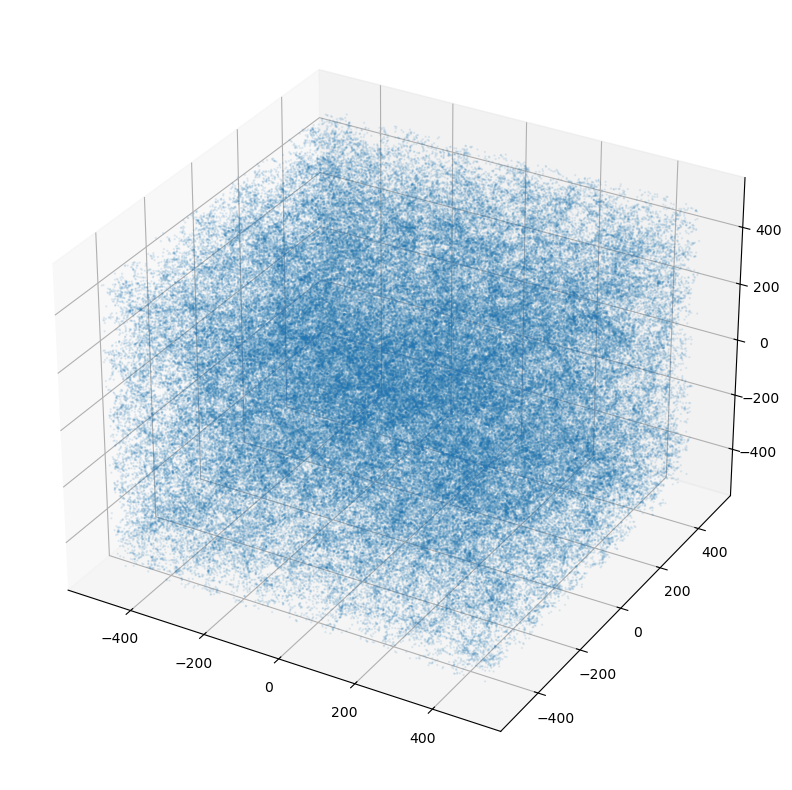

In [12]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker='.', alpha=0.1)

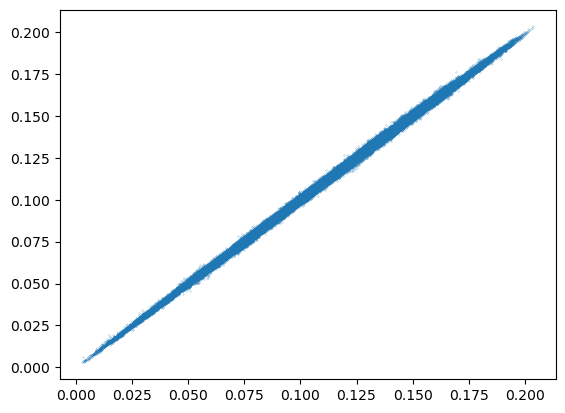

In [13]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1)

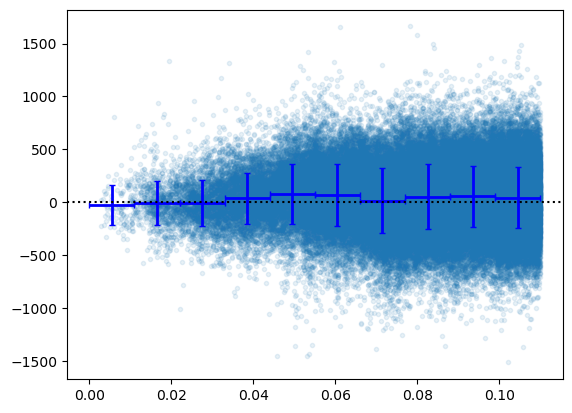

In [15]:
z_max = 0.11
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0, z_max-width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
plt.scatter(halos.z[halos.z < z_max],
            halos.vpec[halos.z < z_max],
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [halos.vpec[filt].mean() for filt in in_bins],
             yerr=[halos.vpec[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

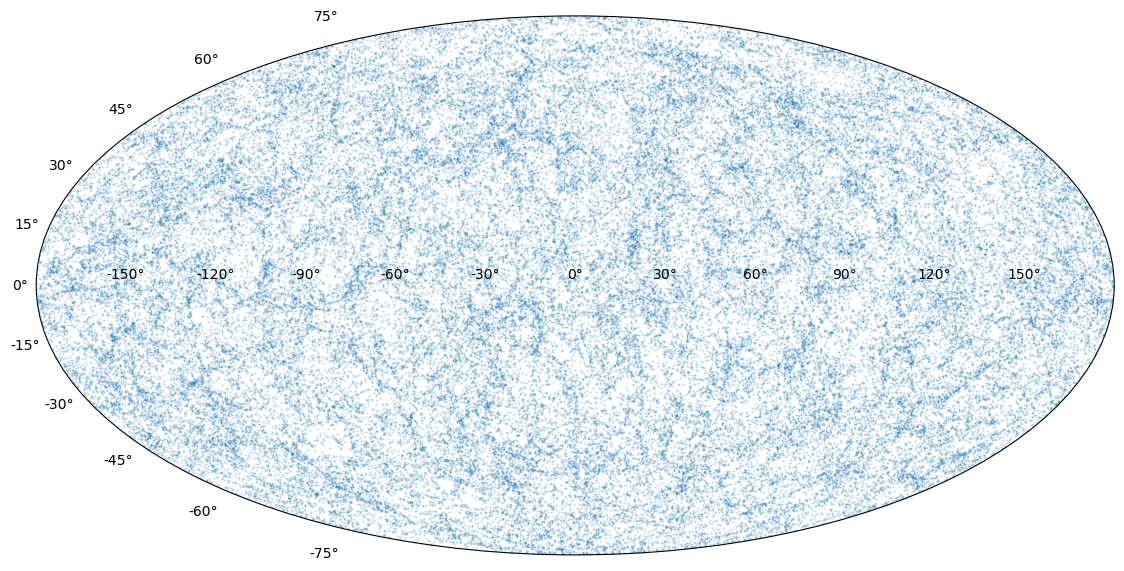

In [16]:
fig, ax  = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection='mollweide'))
ax.scatter(halos.ra[halos.z_cosmo<0.1]*np.pi/180, halos.dec[halos.z_cosmo<0.1]*np.pi/180, marker=".", s=2, alpha=0.2)

## SNe Generation from 2M++

### ZTF

In [65]:
survey=extract_ztf()

snia = SNeIa_full_bgs(filename="/cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
# snia.cosmology=cosmo
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
              zmax=0.1,
              skyarea=snia.area,
              inplace=True)

2025-01-24 13:45:22,030 INFO Loading ZTF survey
2025-01-24 13:45:29,716 INFO Found .csv file at /cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv with columns Index(['pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c', 'halo_id', 'Rmax',
       'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')
/cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")


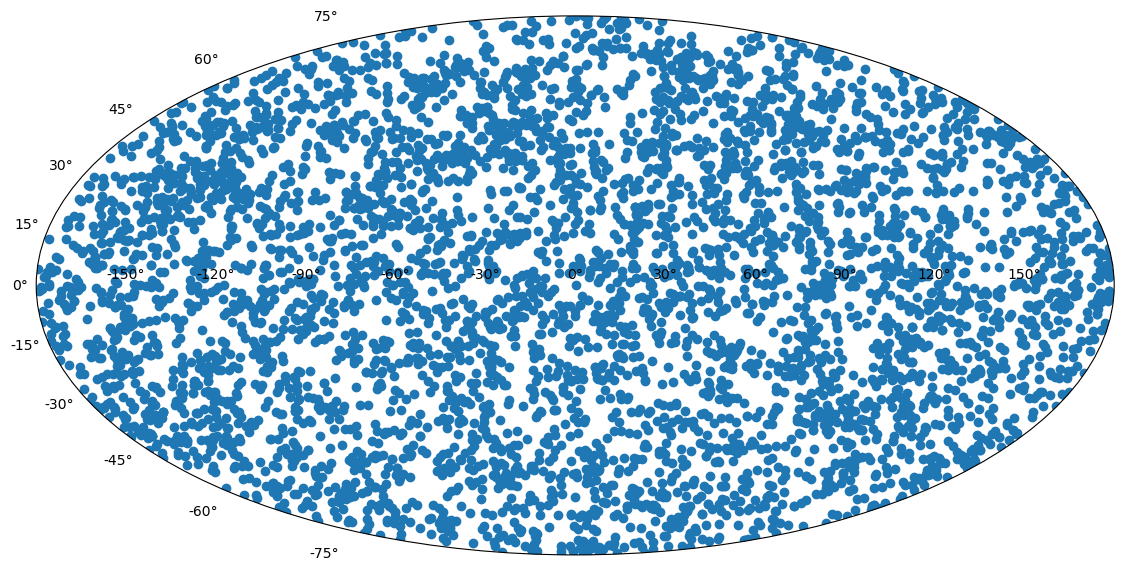

In [166]:
fig, ax = plt.subplots(figsize=(20,7), subplot_kw=dict(projection="mollweide"))
plt.scatter(snia.data.ra*np.pi/180, snia.data.dec*np.pi/180)

In [167]:
lightcurves, fieldids = skysurvey.DataSet.realize_survey_target_lcs(snia, survey, incl_error=True)


/cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/ztffields/projection.py:151: UserWarning: you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas
  warnings.warn("you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas")


In [168]:
import itertools

In [169]:
def chunk_dfs(dfs, chunk_size):
    """" yields n dataframes at a time where n == chunksize """
    dfs_out = []
    for df in dfs:
        dfs_out.append(df)
        if len(dfs_out) == chunk_size:
            yield dfs_out, chunk_size
            dfs_out = []
    if dfs_out:
        yield dfs_out, len(dfs_out)

def concat_chunk(dfs, **kwargs):
    return pandas.concat((df for df in dfs), **kwargs)

def eff_concat(dfs, chunk_size, keys=None, **kwargs):
    dfs, dfs_len = itertools.tee(dfs, 2)
    if len(list(dfs_len)) < chunk_size:
        return concat_chunk(dfs, keys=keys, **kwargs)
    else:
        return eff_concat((concat_chunk(dfs, keys=keys[i*chunk_size:i*chunk_size+l], **kwargs) for i, (dfs, l) in enumerate(chunk_dfs(dfs, chunk_size))), chunk_size)

In [170]:
lc = eff_concat(lightcurves, 1000, keys=fieldids)

In [171]:
dset=skysurvey.DataSet(lc.reset_index(survey.fieldids.names), targets=snia, survey=survey)

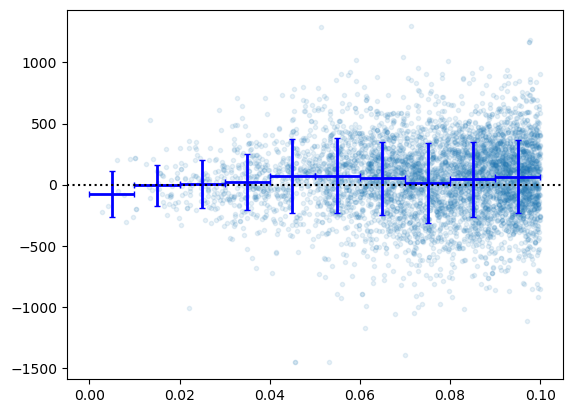

In [172]:
z_max = 0.1
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
pv = (dset.targets.data.z - dset.targets.data.z_cosmo)*1e-3*c/(1+dset.targets.data.z_cosmo)
in_bins = [(dset.targets.data.z > z_min) & (dset.targets.data.z < z_min + width) for z_min in bounds]
plt.scatter(dset.targets.data.z,
            pv,
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

In [173]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

In [97]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'rb') as file:
    data = pickle.load(file)
    lc = pickle.load(file)
survey=extract_ztf()
snia = SNeIa_full_bgs(filename="/cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
snia.set_data(data.copy())
dset = skysurvey.DataSet(data=lc, 
                         targets=snia,
                         survey=survey)

2025-01-24 13:52:14,136 INFO Loading ZTF survey
2025-01-24 13:52:21,654 INFO Found .csv file at /cfs/home/angi0819/Projet-LPNHE/Projet-LPNHE/data/2M++_subhalo_0.csv with columns Index(['pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c', 'halo_id', 'Rmax',
       'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')


2025-01-24 13:52:22,127 WARNING Pandas support in corner is deprecated; use ArviZ directly


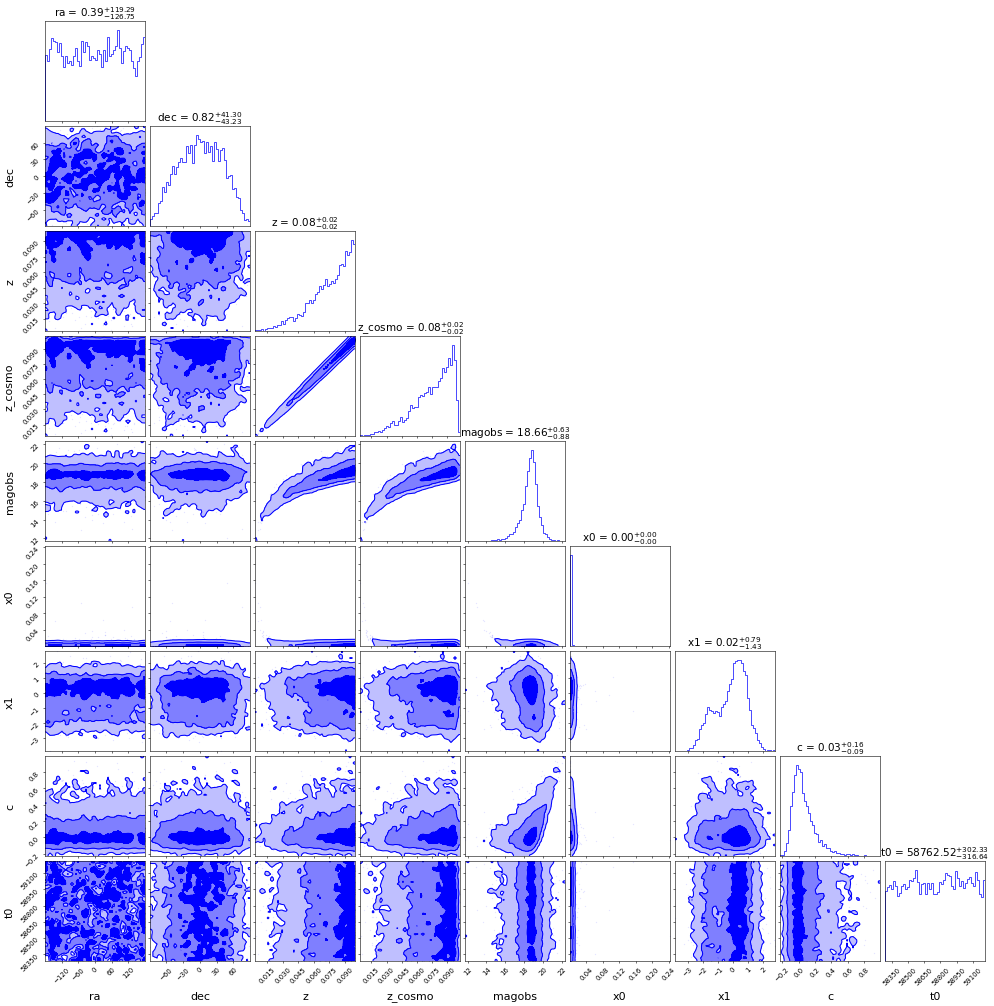

In [98]:
_=corner_(dset.targets.data, var_names=["ra","dec","z","z_cosmo","magobs","x0","x1","c","t0"])

In [63]:
from shapely import geometry

with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'rb') as file:
    dset = pickle.load(file)

In [66]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

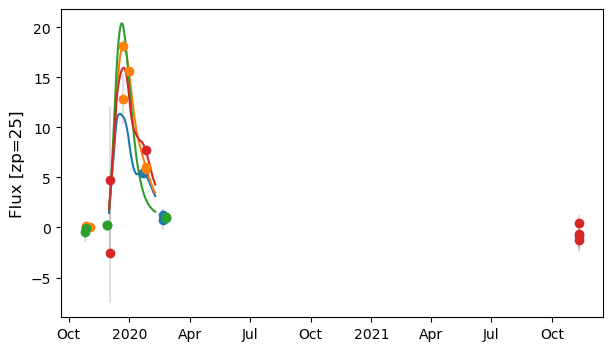

In [91]:
_=dset.show_target_lightcurve()

### Simple SALT fit after pets `make_sample.py`

In [8]:
lc_ztf = pandas.read_csv("data/pets_2M++/mock_lc.csv", index_col=0).reset_index(drop=True)
lc_ztf.name = 'ZTF_' + lc_ztf.sn.astype(str)
lc_snls = pandas.read_csv("data/pets_snls/mock_lc.csv", index_col=0)
lc_snls.lc += lc_ztf.lc.nunique()
lc_snls.name = 'SNLS_' + lc_snls.sn.astype(str)
lc_hsc = pandas.read_csv("data/pets_hsc/mock_lc.csv", index_col=0)
lc_hsc.lc += lc_ztf.lc.nunique() + lc_snls.lc.nunique()
lc_hsc.name = 'HSC_' + lc_hsc.sn.astype(str)
lc_tot = pandas.concat([lc_ztf,
                        lc_snls,
                        lc_hsc
                       ])
lc_tot.valid = lc_tot.valid.astype(bool)

data_ztf_pets = pandas.read_csv("data/pets_2M++/mock_sne.csv", index_col=0)
data_snls_pets = pandas.read_csv("data/pets_snls/mock_sne.csv", index_col=0)
data_hsc_pets = pandas.read_csv("data/pets_hsc/mock_sne.csv", index_col=0)
data_tot_pets = pandas.concat([data_ztf_pets,
                               data_snls_pets,
                               data_hsc_pets
                         ])
data_tot_pets.valid = data_tot_pets.valid.astype(bool)
data_tot_pets.reset_index(drop=True, inplace=True)
data_tot_pets.name = data_tot_pets.survey + '_' + data_tot_pets.sn.astype(str)

In [9]:
with open("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", "rb") as f:
    data_snls = pickle.load(f)

data_snls["survey"] = "SNLS"

with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'rb') as f:
    data_ztf = pickle.load(f)
data_ztf['survey']='ZTF'

with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'rb') as f:
    data_hsc = pickle.load(f)
data_hsc['survey']='HSC'

data_tot = pandas.concat([data_ztf, data_snls, data_hsc])

data_tot.reset_index(drop=True, inplace=True)
float32_cols = list(data_tot.select_dtypes(include='float32'))
data_tot[float32_cols] = data_tot[float32_cols].astype('float64')
data_tot['name'] = data_tot.survey + '_' + data_tot.index.astype(str)

In [10]:
data_tot_pets.valid*=data_tot_pets.name.isin(lc_tot.name)

data_tot['valid'] = data_tot_pets.valid
data_tot=data_tot[data_tot.valid].copy()
data_tot_pets=data_tot_pets[data_tot_pets.valid].copy()
lc_tot=lc_tot[lc_tot.name.isin(data_tot_pets.name)]

In [11]:
from astropy.table import Table
source = sncosmo.SALT2Source(modeldir='data/SALT_snf/',
                             m0file = 'nacl_m0_test.dat',
                             m1file = 'nacl_m1_test.dat',
                             clfile = 'nacl_color_law_test.dat')
dust = sncosmo.CCM89Dust()
model= sncosmo.Model(source=source, effects=[dust],effect_names=['mw'],effect_frames=['obs'])

def fit_sn(model, sn, data_tot_pets):
    from iminuit.warnings import IMinuitWarning
    import warnings
    warnings.filterwarnings("ignore", category=IMinuitWarning)
    try:
        lc_sn = lc_tot[lc_tot.name==sn]
        lc_sncosmo=Table.from_pandas(lc_sn[['sn','name','mjd','flux','fluxerr','magsys','exptime','valid','lc','band','mag_sky','seeing','zp']])

        model.set(z=data_tot_pets[data_tot_pets.name==sn].zhel.values[0],
                  mwebv=data_tot_pets[data_tot_pets.name==sn].mwebv.values[0], mwr_v=3.1)  # set the model's redshift and MW
        t0=data_tot_pets[data_tot_pets.name==sn].tmax.values[0]
        res, _ = sncosmo.fit_lc(lc_sncosmo, model,['t0', 'x0', 'x1', 'c'],
                                bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3), 't0':(t0-1, t0+1)},phase_range=None,modelcov=True)
        return res
    except:
        return None

In [12]:
data_tot_pets['magobs'] = -2.5*np.log10(data_tot_pets.x0) + model.source.peakmag("bessellb", "ab")
data_tot_pets.set_index(data_tot_pets["name"], inplace=True)
data_tot.set_index(data_tot_pets["name"], inplace=True)

[]

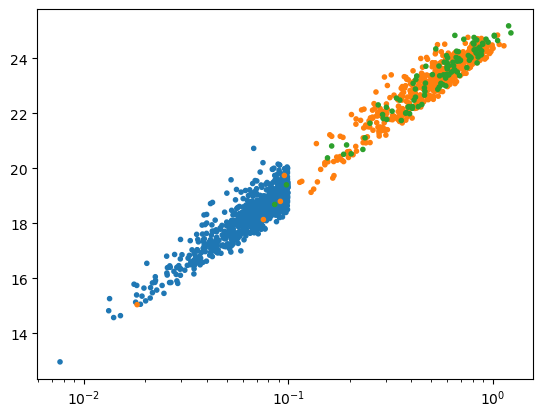

In [11]:
plt.scatter(data_tot.z,
            data_tot.magobs,
            c=[survey_colors[s] for s in data_tot.survey],
            marker=".")
# plt.scatter(data_tot_pets.zhel,
#             data_tot_pets.magobs,
#             c=[survey_colors[s] for s in data_tot.survey],
#             marker='.')
plt.semilogx()

In [12]:
results = [fit_sn(model, sn, data_tot_pets) for sn in tqdm(data_tot_pets.name)]

  0%|          | 0/1415 [00:00<?, ?it/s]

In [13]:
with open("outdir/ztf_2M++_snls_hsc_raw.pkl", "wb") as file:
    pickle.dump(results,file)

In [14]:
values = pandas.DataFrame([res.parameters[[0, 1, 2,3,4]] for res in results],
                 columns=["z", "t0", "x0","x1","c"],
                 index=lc_tot[lc_tot.valid==1].name.unique())

In [15]:
covs = {sn:res.covariance for res, sn in zip(results, lc_tot[lc_tot.valid==1].name.unique())}

In [16]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "wb") as file:
    pickle.dump(values, file)
    pickle.dump(covs, file)

In [17]:
data_tot_pets.valid = [res.success for res in results]

In [13]:
with open("outdir/ztf_2M++.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [14]:
new_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            covs[i][1:,1:],
        ),
        jnp.array(
            [
                [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                [0, 1, 0],
                [0, 0, 1],
            ]
        ),
    )
    for i in lc_tot[lc_tot.valid==1].name.unique()
}


In [15]:
values["magobs"] = -2.5*np.log10(values["x0"]) + model.source.peakmag("bessellb", "ab")

values['valid'] = data_tot_pets.valid

In [16]:
values["err_t0"] = [np.sqrt(covs[i][0,0]) for i in values.index]
values["err_x0"] = [np.sqrt(covs[i][1,1]) for i in values.index]
values["err_x1"] = [np.sqrt(covs[i][2,2]) for i in values.index]
values["err_c"] = [np.sqrt(covs[i][3,3]) for i in values.index]
values["err_magobs"] = [np.sqrt(new_covs[i][0,0]) for i in values.index]

In [17]:
values.loc[data_tot_pets.survey=="ZTF", 'valid'] &= (np.abs(values[data_tot_pets.survey=="ZTF"].x1) < 3.9) &  \
                                                    (values[data_tot_pets.survey=="ZTF"].err_x1 < 1) & \
                                                    (np.abs(values[data_tot_pets.survey=="ZTF"].c) < 2) & \
                                                    (values[data_tot_pets.survey=="ZTF"].err_c < 0.1) & \
                                                    (values.err_t0 < .1)

In [18]:
values["mu"] = values.magobs + 0.14*values.x1 - 3.15*values.c
data_tot_pets["mu"] = data_tot_pets.magobs + 0.14*data_tot_pets.x1 - 3.15*data_tot_pets.c


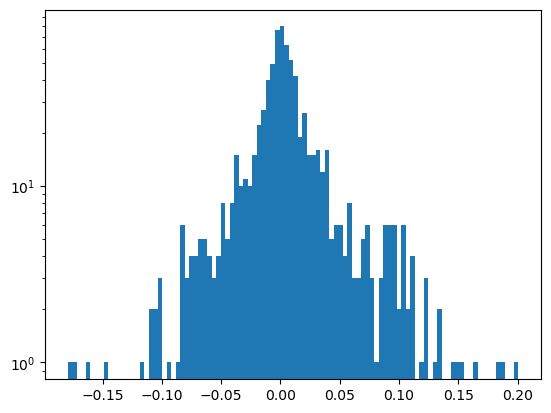

In [27]:
_=plt.hist(data_tot_pets["mu"][values.valid] - \
           values["mu"][values.valid], bins=100, log=True)

2025-01-29 11:30:35,400 WARNING Pandas support in corner is deprecated; use ArviZ directly


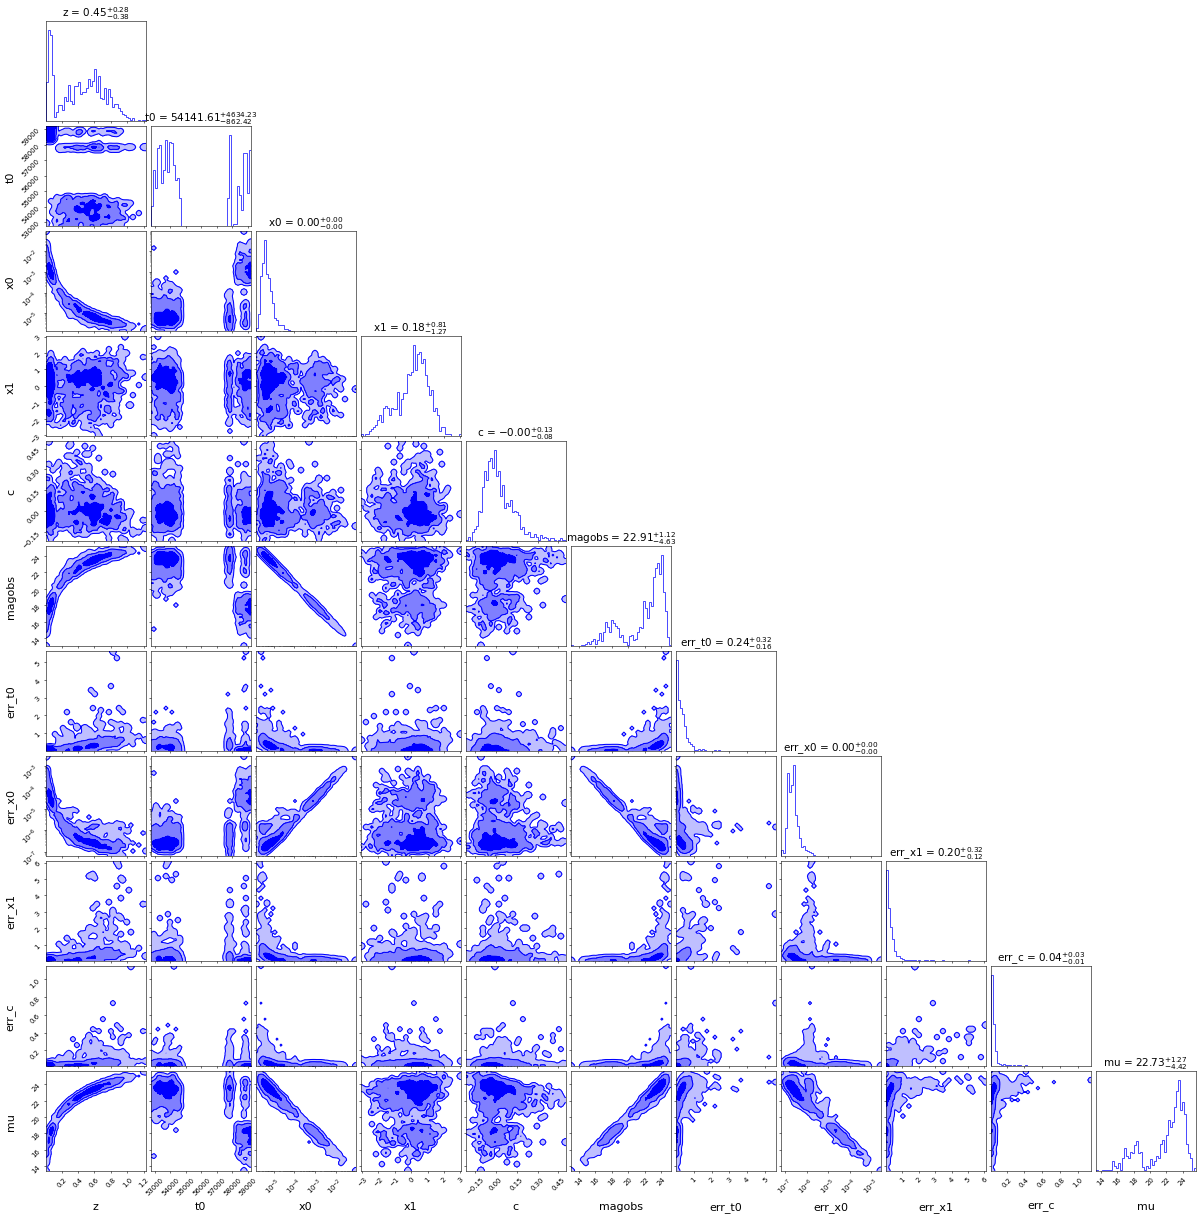

In [28]:
_=corner_(values[values.valid],
        var_names=["z", "t0", "x0", "x1", "c", "magobs", "err_t0", "err_x0", "err_x1", "err_c", "mu"],
         axes_scale=['linear', 'linear', 'log', 'linear', 'linear', 'linear', 'linear', 'log', 'linear', 'linear', 'linear'])

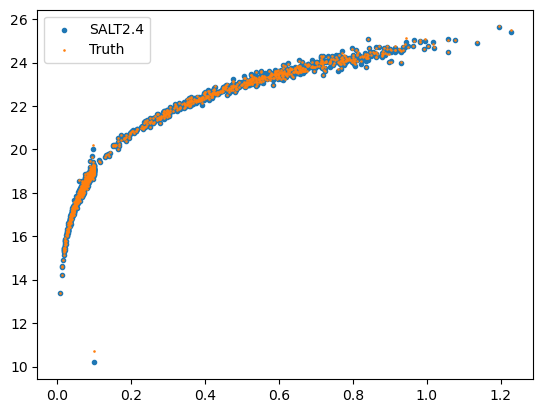

In [25]:
plt.scatter(values[data_tot_pets.valid].z,
            values[data_tot_pets.valid].magobs + 0.14*values[data_tot_pets.valid].x1 - 3.15*values[data_tot_pets.valid].c,
            marker=".",
            label='SALT2.4')
plt.scatter(data_tot_pets[data_tot_pets.valid].zhel,
            data_tot_pets[data_tot_pets.valid].magobs + 0.14*data_tot_pets[data_tot_pets.valid].x1 - 3.15*data_tot_pets[data_tot_pets.valid].c,
            s=3,
            marker=".",
            label="Truth")
plt.legend()

In [69]:
def mag_cosmo(z):
    return jnp.array(cosmo.distmod(z).value - 19.3)

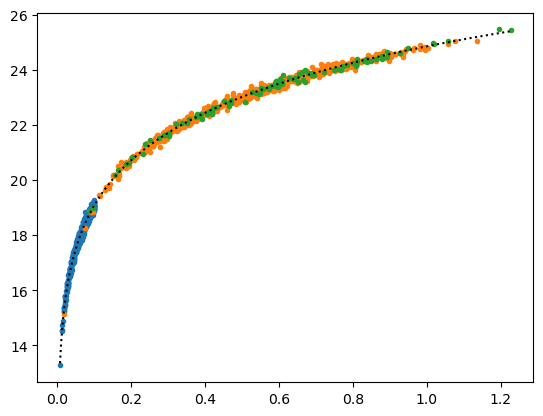

In [63]:
plt.scatter(data_tot[data_tot.survey=="ZTF"].z,
            data_tot[data_tot.survey=="ZTF"].magobs + 0.14*data_tot[data_tot.survey=="ZTF"].x1 - 3.15*data_tot[data_tot.survey=="ZTF"].c,
            marker=".",
            label="ZTF")
plt.scatter(data_tot[data_tot.survey=="SNLS"].z,
            data_tot[data_tot.survey=="SNLS"].magobs + 0.14*data_tot[data_tot.survey=="SNLS"].x1 - 3.15*data_tot[data_tot.survey=="SNLS"].c,
            marker=".",
            label="SNLS")
plt.scatter(data_tot[data_tot.survey=="HSC"].z,
            data_tot[data_tot.survey=="HSC"].magobs + 0.14*data_tot[data_tot.survey=="HSC"].x1 - 3.15*data_tot[data_tot.survey=="HSC"].c,
            marker=".",
            label="HSC")
plt.plot(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000),
         mag_cosmo(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000)),
         linestyle=':',
         color='k')

In [64]:
mag_to_z = interp1d(mag_cosmo(np.linspace(1e-5, 0.3, 10000)),np.linspace(1e-5, 0.3, 10000))

In [65]:
data_tot_pets['err_magobs'] = 2.5*data_tot_pets.err_x0/(np.log(10) * data_tot_pets.x0)

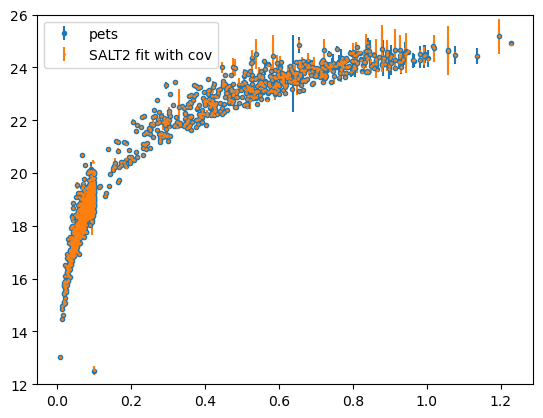

In [66]:
plt.errorbar(data_tot_pets[data_tot_pets.valid].zhel,
             data_tot_pets[data_tot_pets.valid]["magobs"],
             data_tot_pets[data_tot_pets.valid]["err_magobs"],
             linestyle='',
             marker='.',
             label='pets')

plt.errorbar(values[data_tot_pets.valid].z,
             values[data_tot_pets.valid].magobs,
             values[data_tot_pets.valid].err_magobs,
             linestyle='',
             markersize=2,
             marker='.',
             label='SALT2 fit with cov')
plt.ylim(12,26)
plt.legend()

In [67]:
mu_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [1, 0.14, -3.15],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            new_covs[i],
        ),
        jnp.array(
            [
                [1, 0, 0],
                [0.14, 1, 0],
                [-3.15, 0, 1],
            ]
        ),
    )
    for i in values.index
}
values['mu'] = values.magobs + 0.14*values.x1 - 3.15*values.c
values['err_mu'] = jnp.sqrt(np.array([mu_covs[i][0,0] for i in values.index]))

In [68]:
data_tot_pets["mu"] = data_tot_pets.magobs + \
                        0.14*data_tot_pets.x1 - \
                        3.15*data_tot_pets.c

data_tot_pets["err_mu"] = np.sqrt(data_tot_pets['err_magobs']**2 + \
                        0.14*data_tot_pets['err_x1']**2 + \
                        3.15*data_tot_pets['err_c']**2)

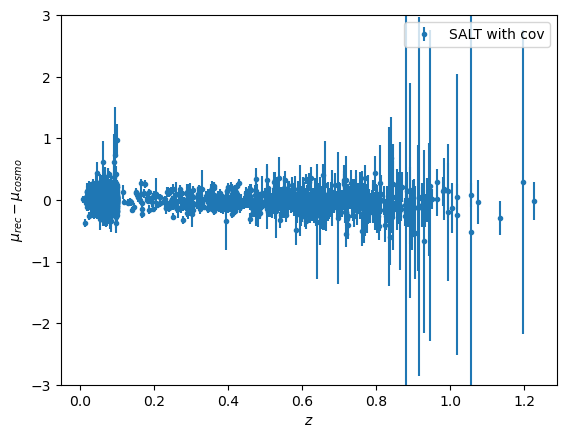

In [79]:
# plt.errorbar(data_tot_pets[values.valid].zhel,
#              data_tot_pets[values.valid].mu - mag_Planck15(data_tot_pets.zhel[values.valid]),
#              data_tot_pets[values.valid].err_mu,
#              linestyle='',
#              markersize=2,
#              marker='.',
#              label='PETS')

plt.errorbar(values[data_tot_pets.valid].z,
             values[data_tot_pets.valid].mu - mag_Planck15(values[data_tot_pets.valid].z),
             values[data_tot_pets.valid].err_mu,
             linestyle='',
             marker='.',
             label='SALT with cov')
plt.ylim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu_{rec} - \mu_{cosmo}$")
plt.legend()

In [71]:
use_vpec = (data_tot_pets.valid) & (data_tot_pets.survey=='ZTF')
z_cosmo_pets = mag_to_z(values[use_vpec].mu)

In [72]:
errp_z_cosmo_pets = mag_to_z(values[use_vpec].mu + values[use_vpec].err_mu) - z_cosmo_pets
errm_z_cosmo_pets = z_cosmo_pets - mag_to_z(values[use_vpec].mu -\
                             values[use_vpec].err_mu)

In [73]:
z_cosmo=mag_to_z(data_tot[data_tot.survey=="ZTF"].magobs + 0.14*data_tot[data_tot.survey=="ZTF"].x1 - 3.15*data_tot[data_tot.survey=="ZTF"].c)

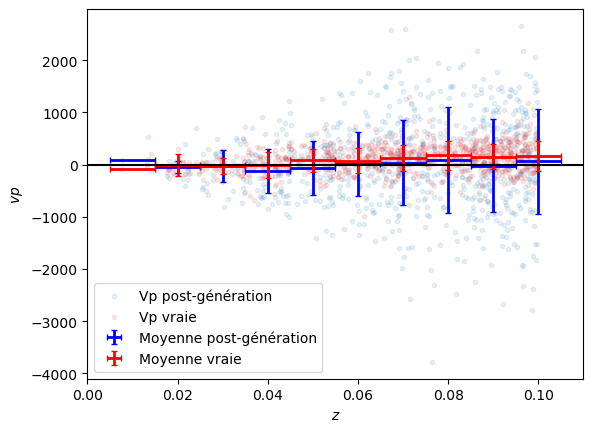

In [74]:
data_ztf = data_tot[data_tot.survey=="ZTF"]
pv = (data_ztf.z-z_cosmo)*c*1e-3/(1+z_cosmo)
true_pv = (data_ztf.z-data_ztf.z_cosmo)*c*1e-3/(1+data_ztf.z_cosmo)

z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins+1)
width = z_max/n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z< z_min + width) for z_min in bounds]

plt.scatter(data_ztf.z,
            pv,
            marker=".",
            alpha=0.1,
            label="Vp post-génération")
plt.scatter(data_ztf.z,
            true_pv,
            marker=".",
            color="tab:red",
            alpha=0.1,
            label="Vp vraie")

plt.errorbar(bounds+width,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="Moyenne post-génération")

plt.errorbar(bounds+width,
             [true_pv[filt].mean() for filt in in_bins],
             yerr=[true_pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='red',
             linewidth=2,
             capsize=2,
             label="Moyenne vraie")

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color='k')

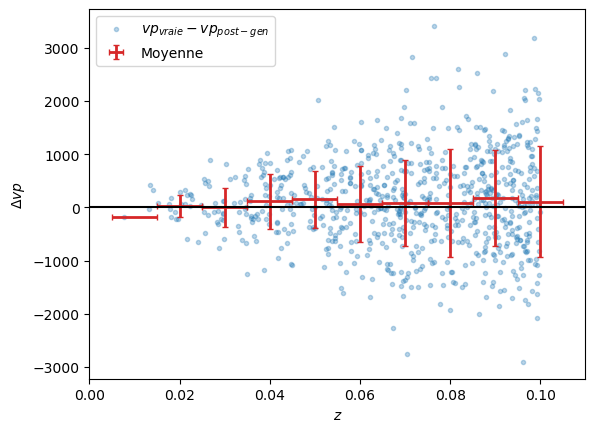

In [75]:
plt.scatter(data_ztf.z,
            true_pv - pv,
            marker=".",
            alpha=0.3,
            label="$vp_{vraie} - vp_{post-gen}$")

plt.errorbar(bounds + width,
             [(true_pv - pv)[filt].mean() for filt in in_bins],
             yerr=[(true_pv - pv)[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()

plt.axhline(0, color='k')

In [76]:
# np.array([errp_z_cosmo_pets, errm_z_cosmo_pets])*c.value*1e-3

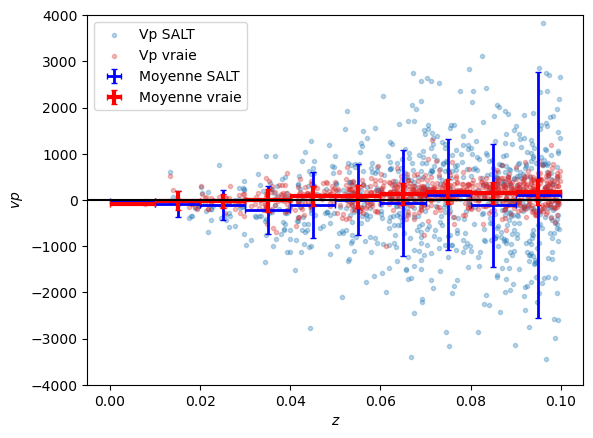

In [77]:
z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins+1)
width = z_max/n_bins

data_used = data_ztf[(data_tot_pets[data_tot_pets.survey=="ZTF"].valid) & (data_ztf.z < 0.1)]

in_bins = [(data_used.z > z_min) & (data_used.z< z_min + width) for z_min in bounds]

pets_pv = (data_used.z - z_cosmo_pets)*c*1e-3/(1+z_cosmo_pets[values[use_vpec].z < 0.1])
true_pv = (data_used.z - data_used.z_cosmo)*c*1e-3/(1+data_used.z_cosmo)

plt.scatter(data_used.z,
            pets_pv,
            marker=".",
            alpha=0.3,
            label="Vp SALT")
plt.scatter(data_used.z,
            true_pv,
            marker=".",
            color="tab:red",
            alpha=0.3,
            label="Vp vraie")

plt.errorbar(bounds + width/2,
             [pets_pv[filt].mean() for filt in in_bins],
             yerr=[pets_pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="Moyenne SALT")

plt.errorbar(bounds + width/2,
             [true_pv[filt].mean() for filt in in_bins],
             yerr=[true_pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='red',
             linewidth=3,
             capsize=2,
             label="Moyenne vraie")


plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.axhline(0, color='k')

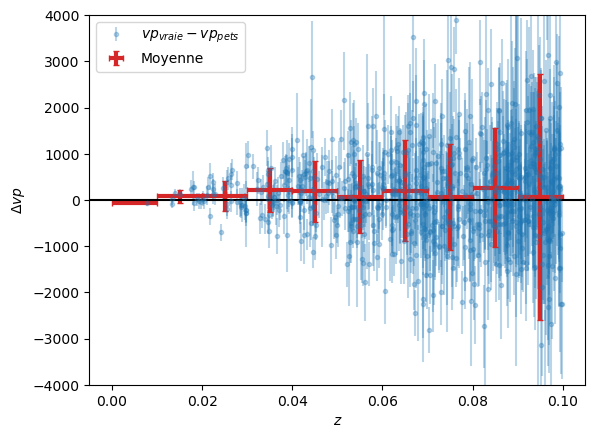

In [78]:
plt.errorbar(data_used.z,
            true_pv - pets_pv,
            np.array([errp_z_cosmo_pets[values[use_vpec].z < 0.1], errm_z_cosmo_pets[values[use_vpec].z < 0.1]])*c.value*1e-3,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{pets}$")
plt.errorbar(bounds + width/2,
             [(true_pv - pets_pv)[filt].mean() for filt in in_bins],
             yerr=[(true_pv - pets_pv)[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='tab:red',
             linewidth=3,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [49]:
np.mean(true_pv - pets_pv), np.std(true_pv - pets_pv)

(45.417960632271985, 1518.275075409649)

In [13]:
filt = (values.c < 0.3) &\
       (values.err_x1 + np.abs(values.x1) < 5) &\
       (values.err_c < .05)
sum(filt)

986

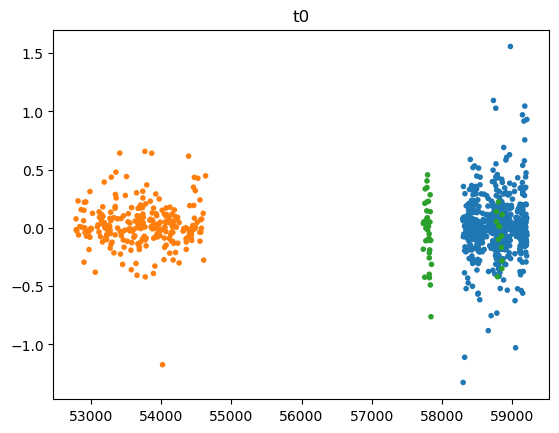

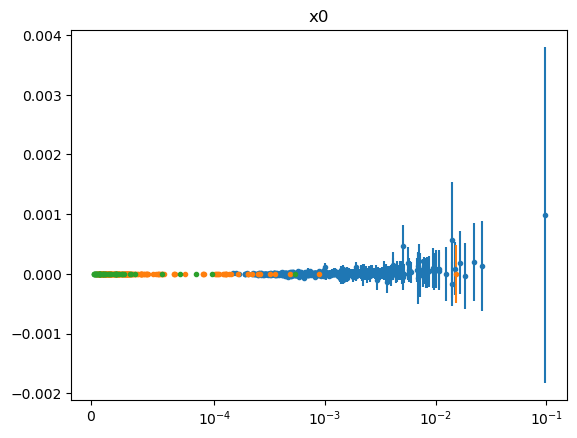

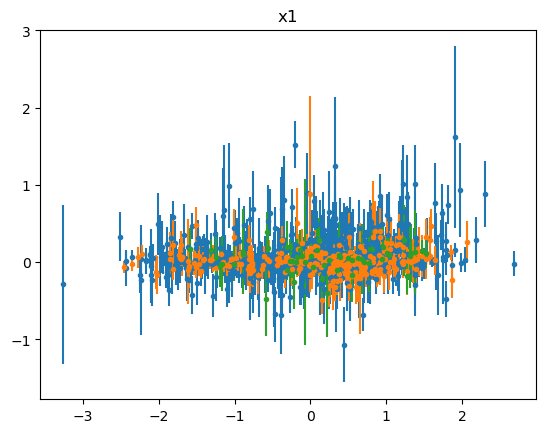

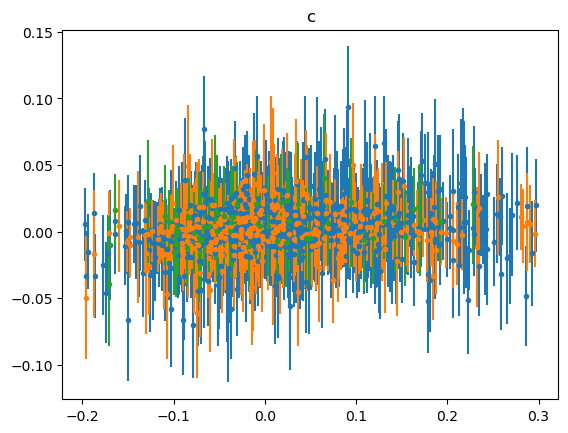

In [54]:
plt.scatter(values[filt].t0,
            values[filt].t0 - data_tot[filt].t0,
            c=[survey_colors[s] for s in data_tot[filt].survey],
            marker='.')
plt.title("t0")
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(values[filt & (data_tot.survey==s)].x0,
                values[filt & (data_tot.survey==s)].x0 - data_tot[filt & (data_tot.survey==s)].x0,
                values[filt & (data_tot.survey==s)].err_x0,
                c=survey_colors[s],
                linestyle='',
                marker='.')
    plt.title("x0")
    plt.semilogx()
    plt.xscale("symlog", linthresh=1e-4)

plt.figure()
for s in survey_colors.keys():

    plt.errorbar(values[filt & (data_tot.survey==s)].x1,
                values[filt & (data_tot.survey==s)].x1 - data_tot[filt & (data_tot.survey==s)].x1,
                values[filt & (data_tot.survey==s)].err_x1,
                c=survey_colors[s],
                linestyle='',
                marker='.')
    plt.title("x1")
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(values[filt & (data_tot.survey==s)].c,
                values[filt & (data_tot.survey==s)].c - data_tot[filt & (data_tot.survey==s)].c,
                values[filt & (data_tot.survey==s)].err_c,
                c=survey_colors[s],
                linestyle='',
                marker='.')
    plt.title("c")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [24]:
from astropy.cosmology import Planck15, Planck18
# cosmo = Planck15

In [19]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [23]:
def flcdm(params, explanatory):
    p = {'Omega_m': params['Omega_m'],
         'Omega_gamma': cosmo.Ogamma0, 
         'w': -1.0,
         'H0': params["H0"],
         'Omega_k': cosmo.Ok0
       }
    return mu(p, explanatory['z']) - 19.3

In [25]:
params = dict(H0=jnp.array([cosmo.H0.value]),
          Omega_m=jnp.array([cosmo.Om0]),
          Omega_gamma=jnp.array([cosmo.Ogamma0]),
          Omega_k=jnp.array([cosmo.Ok0]),
          w=jnp.array([-1.0]),
          coef=jnp.array([-0.14, 3.15]),
          sigma_int=jnp.array([jnp.array([0.1])]),
         )

In [27]:
source = sncosmo.get_source("salt2", version='2.4')
model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])


In [29]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [30]:
values = values[values.valid].copy()

In [31]:
from scipy.linalg import block_diag
full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]


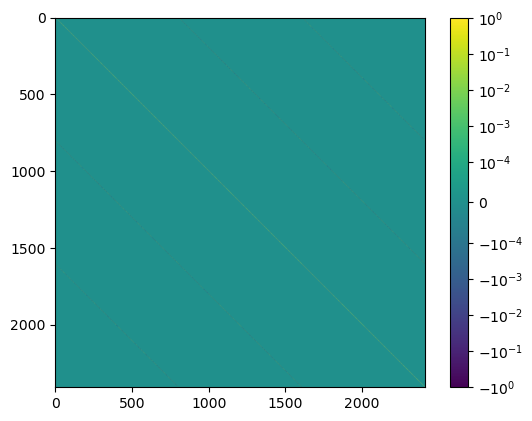

In [32]:
from matplotlib.colors import SymLogNorm
plt.imshow(jnp.diag(1/jnp.sqrt(jnp.diag(full_cov_sorted))) @ full_cov_sorted @ jnp.diag(1/jnp.sqrt(jnp.diag(full_cov_sorted))),
           norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-4))
plt.colorbar()

In [33]:
values['survey']=values.index.map(lambda s: s.split('_')[0])

In [37]:
filt = (values.c < 0.3) &\
       (values.err_x1 + np.abs(values.x1) < 5) &\
       (values.err_c < .05) #&\
       #((values.survey != 'ZTF') | (values.z < 0.1))
sum(filt)

483

In [38]:
surveys = set(values[filt]['survey'])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]['survey']])

In [39]:
obs = Obs(mag=jnp.array(values[filt].magobs),
          variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]))

In [40]:
exp=dict(z=jnp.array(values[filt].z),
         survey_id=survey_id,
         survey_map=survey_map,
        )

In [41]:
n = len(values)

In [42]:
cov = FullCovariance(
    full_cov_sorted[:n, :n], full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [43]:
cov = cov.select(filt.values)

In [44]:
exp['map_survey'] = {v:k for v,k in zip(exp['survey_map'].values(), exp['survey_map'].keys())}

In [46]:
x0 = dict(H0=jnp.array([cosmo.H0.value]),
          Omega_m=jnp.array([cosmo.Om0]),
          coef=jnp.array([-0.14, 3.15]),
          variables=jnp.array(obs.variables.reshape((2, -1))),
          sigma_int=jnp.array([0.1]),
         )

In [47]:
exp

{'z': Array([0.02418685, 0.05293635, 0.04990402, 0.07213029, 0.06370868,
        0.04460482, 0.01325689, 0.08877846, 0.07938524, 0.06961993,
        0.09946185, 0.02854166, 0.03568567, 0.07944772, 0.05676717,
        0.07037559, 0.0858333 , 0.05244495, 0.02636115, 0.07677481,
        0.02123682, 0.08161997, 0.07112984, 0.05566861, 0.05808923,
        0.03918697, 0.0578634 , 0.07167441, 0.01512978, 0.08816491,
        0.08169589, 0.03471557, 0.06737345, 0.03309089, 0.06263711,
        0.04819751, 0.07453017, 0.06081246, 0.0388577 , 0.08303925,
        0.03835449, 0.02670828, 0.06858095, 0.03614796, 0.03862729,
        0.05928656, 0.038546  , 0.05554288, 0.06567034, 0.04379191,
        0.03239601, 0.08862244, 0.09757773, 0.01818321, 0.06412463,
        0.08525132, 0.02469489, 0.07295467, 0.05005861, 0.01401713,
        0.02168903, 0.03922131, 0.06697123, 0.03588729, 0.02036003,
        0.06903811, 0.07525276, 0.04459179, 0.06597589, 0.02650414,
        0.02856163, 0.05477485, 0.03555187,

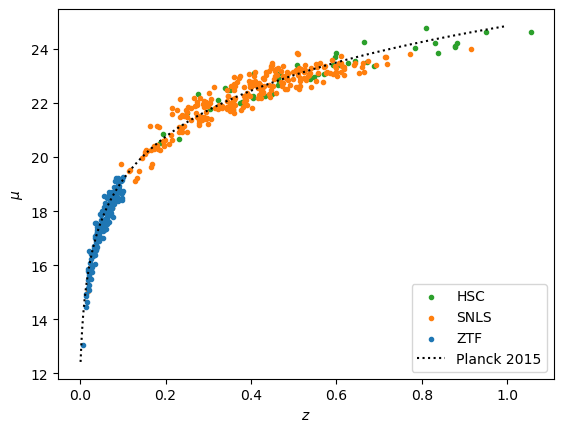

In [48]:
for survey in exp["survey_map"].keys():
    plt.scatter(exp['z'][exp['survey_id'] == exp['survey_map'][survey]],
                obs.mag[exp['survey_id'] == exp['survey_map'][survey]], # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
                c = survey_colors[survey],
                marker=".",
                label=survey)

plt.plot(np.linspace(1e-3, 1, 1000),
         flcdm(params, {'z':jnp.linspace(5e-3, 1, 1000)}),
         linestyle=':',
         color='k',
         label="Planck 2015")
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()


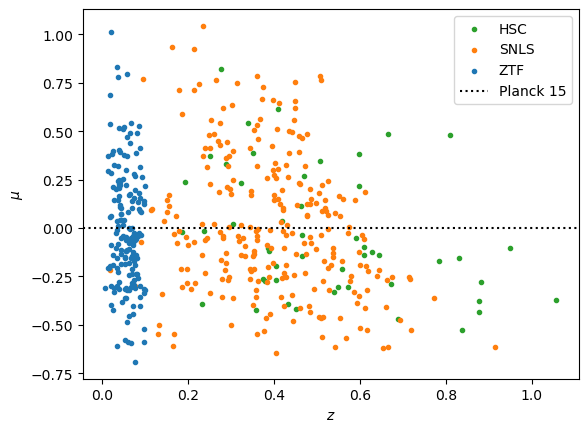

In [49]:
for survey in exp["survey_map"].keys():
    plt.scatter(exp['z'][exp['survey_id'] == exp['survey_map'][survey]],
                obs.mag[exp['survey_id'] == exp['survey_map'][survey]] - \
                flcdm(params, {'z':exp['z'][exp['survey_id'] == exp['survey_map'][survey]]}), 
                # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
                c = survey_colors[survey],
                marker=".",
                label=survey)

plt.axhline(0,
         linestyle=':',
         color='k',
         label="Planck 15")
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()


In [50]:
L = lambda x : likelihood(x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False)

In [51]:
L(x0)

Array(-1462.41110957, dtype=float64)

In [52]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

iter 0/1000. Loss: -1.5e+03->-1.6e+03(-96), ρ=0.82, λ=3000.0
iter 1/1000. Loss: -1.6e+03->-1.7e+03(-1.6e+02), ρ=0.85, λ=900.0
iter 2/1000. Loss: -1.7e+03->-1.8e+03(-63), ρ=0.58, λ=900.0
iter 3/1000. Loss: -1.8e+03->-1.8e+03(-8.8), ρ=0.76, λ=270.0
iter 4/1000. Loss: -1.8e+03->-1.8e+03(-9.8), ρ=0.86, λ=81.0
iter 5/1000. Loss: -1.8e+03->-1.8e+03(-15), ρ=0.86, λ=24.3
iter 6/1000. Loss: -1.8e+03->-1.8e+03(-18), ρ=0.80, λ=7.29
iter 7/1000. Loss: -1.8e+03->-1.8e+03(-11), ρ=0.69, λ=7.29
iter 8/1000. Loss: -1.8e+03->-1.8e+03(-1.7), ρ=0.72, λ=7.29
iter 9/1000. Loss: -1.8e+03->-1.8e+03(-0.36), ρ=0.73, λ=7.29


In [ ]:
jax.tree.map(lambda x,y:x-y, res, x0)

In [ ]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1:hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"]*=n["coef"]
flatten_hess = jnp.vstack([np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()]) for k1 in hess.keys()])
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
with open("outdir/edris_2M++_snls_hsc.pkl", 'wb') as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

In [ ]:
from matplotlib.colors import SymLogNorm
plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-6, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [ ]:
potential_keys = ['H0', 'M0', 'Omega_m', 'Omega_r', 'Omega_l', 'coef', 'sigma_int']
latex_keys = {'H0': '$H_0$',
  'M0': '$M_0$',
  'Omega_m': '$\\Omega_m$',
  'Omega_r': '$\\Omega_r$',
  'Omega_l': '$\\Omega_l$',
  'coef': ['$\\alpha$', '$\\beta$'],
  'sigma_int': '$\\sigma_{int}$',
  'alpha': '$\\alpha$',
  'beta': '$\\beta$'}

In [ ]:
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs +=  list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5*n_pars+1, color='r', linestyle=':')
ax.set_xticks(5*np.arange(n_pars+1), _labels)
ax.set_ylabel('Deviation')
plt.errorbar(5*np.arange(n_pars+1), _diffs,
             yerr= jnp.sqrt(jnp.diag(cov_res)[:n_pars+1]),
             linestyle='',
             marker='.',
             capsize=5,
             capthick=.5)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1,1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars+1)*.4):
    fig.text(0, pos, _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}")


In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale('log')
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 0.8, 1000),
        cosmo(x0, {'z':np.linspace(5e-3, 0.8, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)
    
    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z" : exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 0.8, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 0.8, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 0.8, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 0.8, 1000)}) - cosmo(x0, {"z":jnp.linspace(5e-3, 0.8, 1000)}),
            color="tab:blue",
        )
    
    
    ax1.legend()
    ax1.set_ylabel(r"$\mu$")
    
    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")
    
    fig.suptitle(r"Modèle fitté par Edris")


In [ ]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(flcdm(res, {"z":np.linspace(2e-3, 0.3, 10000)}),np.linspace(2e-3, 0.3, 10000))
z_cosmo_salt = mag_to_z(obs.mag[exp['survey_id']==exp['survey_map']["ZTF"]] - \
                        jnp.matmul(res['coef'], res['variables'])[exp['survey_id']==exp['survey_map']["ZTF"]])

In [ ]:
edris_vp = (exp["z"][exp['survey_id']==exp['survey_map']["ZTF"]] - z_cosmo_salt) * c * 1e-3/(1+z_cosmo_salt)

In [ ]:
# plt.scatter(data_tot[(filt) & (data_tot.survey=="ZTF")].z,
#             true_pv[filt],
#             marker=".",
#             alpha=0.3,
#             color="tab:red",
#             label="Vp vraie")

plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            edris_vp,
            marker=".",
            alpha=0.3,
            linestyle='',
            label="Vp edris")

plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             [edris_vp[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) &\
                       (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean() for z_min in np.linspace(0.00, 0.05, 6)],
             yerr=[edris_vp[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                            (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std() for z_min in np.linspace(0.00, 0.05, 6)],
             xerr=0.005,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="moyenne edris")

# plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
#              [true_pv[(data_ztf['z'] > z_min) & (data_ztf['z'] < z_min + 0.01)].mean() for z_min in np.linspace(0.00, 0.05, 6)],
#              yerr=[true_pv[(data_ztf['z'] > z_min) & (data_ztf['z'] < z_min + 0.01)].std() for z_min in np.linspace(0.00, 0.05, 6)],
#              xerr=0.005,
#              linestyle='',
#              color='tab:red',
#              capsize=2,
#              label="moyenne vraie")

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.axhline(0, color='k')

In [ ]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv[filt] - edris_vp,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean()
              for z_min in np.linspace(0.00, 0.05, 6)]
err_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std()
             for z_min in np.linspace(0.00, 0.05, 6)]
plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             mean_delta,
             yerr=err_delta,
             xerr=0.005,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [ ]:
(true_pv[filt] - edris_vp).values.mean()